# Data Preprocessing for LeiDAN

### 1. Parse data and load metadata

In [ ]:
!pip install cmappy
!pip install scanpy
import scanpy as sc
from cmapPy.pandasGEXpress.parse import parse
import pandas as pd

# load signatures
parse_gctx = parse('./level5_beta_trt_cp_n720216x12328.gctx')

# load signature and compound metadata
metadata = pd.read_csv('./siginfo_beta.txt',delimiter='\t')
compound_info = pd.read_csv('./compoundinfo_beta.txt',delimiter='\t')
metadata = metadata.merge(compound_info,on=['pert_id','cmap_name'])

# get chosen subset
subset = metadata[(metadata['pert_type']=='trt_cp')&
                  (metadata['cell_iname'].isin(['MCF7']))&
                  (metadata['pert_time'].isin([24]))&
                  (metadata['pert_dose'].isin([10]))&
                  (metadata['nsample']>=3)&
                  (metadata['is_hiq']==1)].reset_index(drop=True)

# get international chemical identifiers (inchi)
atc_map = subset[['inchi_key']].drop_duplicates().reset_index(drop=True)



/home/jwinchel/miniconda3/envs/pfs/lib/python3.12/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/home/jwinchel/miniconda3/envs/pfs/lib/python3.12/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))


### 2. Query ChEMBL for ATC classifications

In [ ]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("./chembl_36/chembl_36_sqlite/chembl_36.db")

query = """
SELECT
    cs.standard_inchi_key AS inchi_key,
    md.chembl_id,
    md.pref_name,
    md.max_phase,
    atc.level5 AS atc_code,
    ac.level1,
    ac.level2,
    ac.level3,
    ac.level4,
    ac.who_name AS atc_name,
    ac.level1_description,
    ac.level2_description,
    ac.level3_description,
    ac.level4_description
FROM compound_structures cs
JOIN molecule_dictionary md ON cs.molregno = md.molregno
LEFT JOIN molecule_atc_classification atc ON md.molregno = atc.molregno
LEFT JOIN atc_classification ac ON atc.level5 = ac.level5
"""

# query ChEMBL
chembl = pd.read_sql(query, conn)

# merge atc classifications with drug IDs and save to file
atc_map.merge(chembl,left_on='inchi_key',right_on='inchi_key',how='left').to_csv('drug2atc.csv')



### 3. Save Subset

In [ ]:
# get gene expression as dataframe
gx_data = parse_gctx.data_df.T

# restrict to chosen subset
gx_data = gx_data[gx_data.index.isin(subset['sig_id'])].reset_index().rename(columns={"cid":"sig_id"})

# save gx subset to file
gx_data.to_csv('./mcf7_subset.csv')

### 4. PCA on Gene Expression Data

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# get relevant columns
gx_cols = sorted(gx_data.columns)[:-1]
X = gx_data[gx_cols].values.astype("float32")

# scale values 
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Run PCA to get first 100 PCs
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled).astype("float32")

# format and save pca of subset
pc_cols = [str(i) for i,c in enumerate(X_pca[0])]
gx_pca = pd.DataFrame(gx_data['sig_id'])
gx_pca[pc_cols] = X_pca
gx_pca.to_csv('mcf7_subset_pca.csv')

### 5. UMAP Coordinate Generation

In [ ]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler, normalize

X_norm = normalize(X_pca,norm='l2',axis=1)

mapper = UMAP(n_components=2,n_neighbors=10,
    min_dist=0.3,
    metric="cosine",
    random_state=42
)
gx_data[['UMAP_1','UMAP_2']] = mapper.fit_transform(X_norm)

gx_data[['sig_id','UMAP_1','UMAP_2']].reset_index(drop=True).to_csv('mcf7_umap.csv')

/home/jwinchel/miniconda3/envs/pfs/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='UMAP_1', ylabel='UMAP_2'>

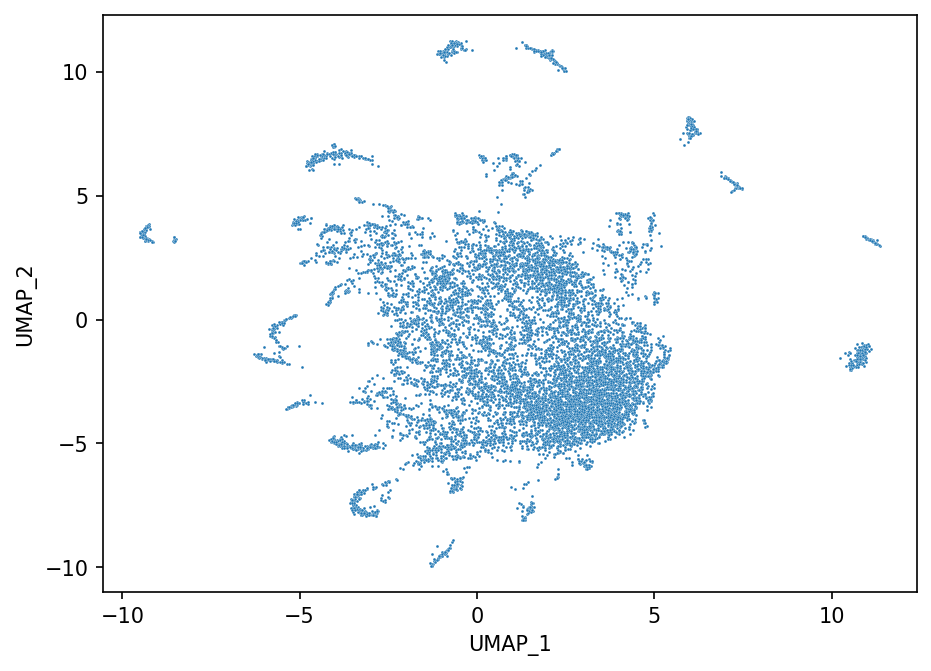

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(7,5),dpi=150)
sns.scatterplot(data=gx_data,x="UMAP_1",y="UMAP_2",s=2)